In [2]:
# Full Clean Double DQN Stock Trading Code Block

import gym
from gym import spaces
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

In [3]:
# 1. Define the Stock Trading Environment
class StockTradingEnv(gym.Env):
    def __init__(self, df):
        super(StockTradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.max_steps = len(df) - 1
        self.action_space = spaces.Discrete(3)  # 0: Hold, 1: Buy, 2: Sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32)
        self.reset()

    def reset(self):
        self.step_idx = 0
        self.balance = 10000
        self.holdings = 0
        self.total_value = self.balance
        return self._get_observation()

    def _get_observation(self):
        idx = min(self.step_idx, self.max_steps)
        price = self.df.iloc[idx]['Close']
        prev_pct_change = self.df['Close'].pct_change().fillna(0).iloc[idx]
        return np.array([price, self.balance, self.holdings, self.total_value, prev_pct_change], dtype=np.float32)

    def step(self, action):
        idx = min(self.step_idx, self.max_steps)
        price = self.df.iloc[idx]['Close']
        reward = 0

        if action == 1 and self.balance >= price:
            self.holdings += 1
            self.balance -= price
        elif action == 2 and self.holdings > 0:
            self.holdings -= 1
            self.balance += price
            reward = price

        self.step_idx += 1
        self.total_value = self.balance + self.holdings * price
        done = self.step_idx >= len(self.df)

        return self._get_observation(), reward, done, {}


In [4]:
# 2. Define the Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [5]:
# 3. Load Stock Dataset
df = pd.read_csv(r'/Users/sailajamorrennagari/Downloads/Stock Market/data/aapl.us.txt')  # Replace with your file path


In [6]:
# 4. Initialize Environment
env = StockTradingEnv(df)

In [7]:
# 5. Initialize Networks
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

qnetwork_local = QNetwork(state_size, action_size)
qnetwork_target = QNetwork(state_size, action_size)
optimizer = optim.Adam(qnetwork_local.parameters(), lr=0.001)

In [8]:
# 6. Set Hyperparameters
memory = deque(maxlen=10000)
batch_size = 64
gamma = 0.99
tau = 0.005

epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995

num_episodes = 500

In [9]:
# 7. Training Loop
portfolio_values = []

for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_portfolio_value = []

    while not done:
        if random.random() < epsilon:
            action = random.choice([0,1,2])  # Hold, Buy, Sell
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_values = qnetwork_local(state_tensor)
            action = torch.argmax(action_values).item()

        next_state, reward, done, _ = env.step(action)
        memory.append((state, action, reward, next_state, done))

        if len(memory) > batch_size:
            experiences = random.sample(memory, batch_size)
            states, actions, rewards, next_states, dones = zip(*experiences)

            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions).unsqueeze(1)
            rewards = torch.FloatTensor(rewards).unsqueeze(1)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones).unsqueeze(1)

            # Double DQN update
            best_actions = torch.argmax(qnetwork_local(next_states), dim=1, keepdim=True)
            Q_targets_next = qnetwork_target(next_states).gather(1, best_actions)
            Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

            Q_expected = qnetwork_local(states).gather(1, actions)

            loss = nn.MSELoss()(Q_expected, Q_targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Soft update target network
            for target_param, local_param in zip(qnetwork_target.parameters(), qnetwork_local.parameters()):
                target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

        state = next_state
        total_portfolio_value.append(env.total_value)

    portfolio_values.append(total_portfolio_value[-1])
    epsilon = max(epsilon_min, epsilon * epsilon_decay)


/var/folders/b9/ssjvpyx17ys4dth9sb2t49jm0000gn/T/ipykernel_28343/4090379208.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  states = torch.FloatTensor(states)


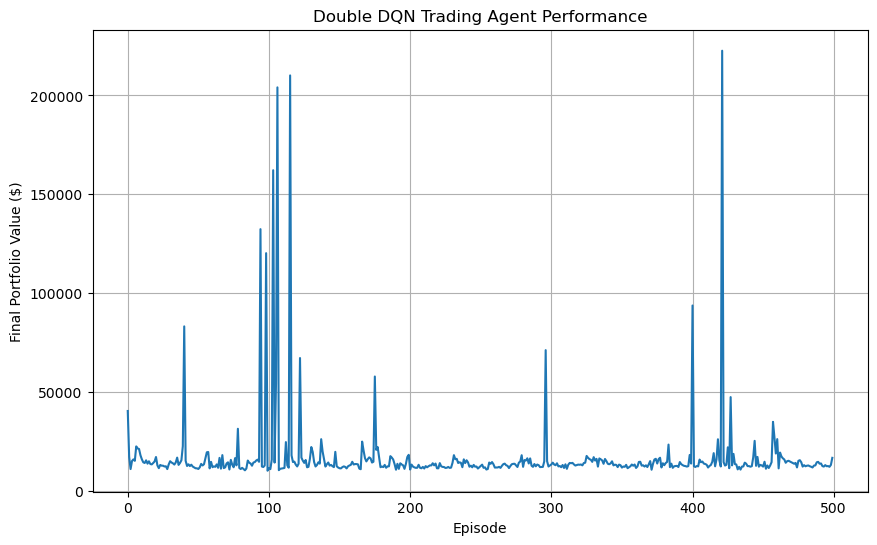

In [11]:
# 8. Plot Final Portfolio Value Over Episodes
plt.figure(figsize=(10,6))
plt.plot(portfolio_values)
plt.xlabel('Episode')
plt.ylabel('Final Portfolio Value ($)')
plt.title('Double DQN Trading Agent Performance')
plt.grid(True)
plt.show()
